In [160]:
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
from datetime import datetime

In [161]:
cluster = Cluster(['127.0.0.1'])
session = cluster.connect()
session.set_keyspace('data_stock')

In [162]:
rows_price = session.execute("""
    SELECT * FROM candlestick_data ALLOW FILTERING
""")
df_cand = pd.DataFrame(rows_price)
df_cand['time'] = pd.to_datetime(df_cand['time'])
df_cand = df_cand.sort_values(['symbol', 'time'])

In [163]:
df_cand.head(10)

,symbol,time,close_price,high_price,low_price,open_price,value,volume
362761,24CS,2022-10-03,10.20,10.20,7.10,7.10,0.0,559474246
362762,24CS,2022-10-04,7.15,11.10,7.15,10.70,0.0,330716796
362763,24CS,2022-10-05,5.15,6.45,5.05,5.85,0.0,361105489
362764,24CS,2022-10-06,5.20,5.45,4.70,5.40,0.0,232684182
362765,24CS,2022-10-07,5.00,5.15,4.76,5.10,0.0,131780847
362766,24CS,2022-10-10,5.00,5.15,4.88,4.98,0.0,51045639
362767,24CS,2022-10-11,4.48,5.05,4.48,5.00,0.0,43520132
362768,24CS,2022-10-12,3.88,4.62,3.88,4.50,0.0,85779188
362769,24CS,2022-10-17,3.68,3.90,3.56,3.88,0.0,9027003
362770,24CS,2022-10-18,3.88,3.90,3.64,3.72,0.0,11371787


In [164]:
import plotly.graph_objects as go

# 🔹 เลือกเฉพาะหุ้น 24CS
ohlc_df = df_cand[df_cand["symbol"] == "24CS"].copy()

# 🔹 จัดการ index
ohlc_df["time"] = pd.to_datetime(ohlc_df["time"])
ohlc_df = ohlc_df.sort_values("time")
ohlc_df = ohlc_df.set_index("time")
ohlc_df.index.name = "Date"

# 🔹 Rename columns ให้ตรงกับ Plotly
ohlc_df = ohlc_df.rename(columns={
    "open_price": "Open",
    "high_price": "High",
    "low_price": "Low",
    "close_price": "Close",
    "volume": "Volume"
})

# 🔹 เลือกแค่ 200 วันล่าสุด (เพื่อให้ดูง่าย)
ohlc_df = ohlc_df.tail(200)

# ✅ วาดกราฟ Candlestick
fig = go.Figure(data=[go.Candlestick(
    x=ohlc_df.index,
    open=ohlc_df['Open'],
    high=ohlc_df['High'],
    low=ohlc_df['Low'],
    close=ohlc_df['Close'],
    name="Candlestick"
)])

# ✅ เพิ่ม Volume
fig.add_trace(go.Bar(
    x=ohlc_df.index,
    y=ohlc_df['Volume'],
    name="Volume",
    marker_color="lightblue",
    opacity=0.5,
    yaxis="y2"
))

# ✅ Layout
fig.update_layout(
    title="24CS Stock Candlestick Chart with Volume",
    yaxis=dict(title="Price", domain=[0.3, 1]),
    yaxis2=dict(title="Volume", domain=[0, 0.25]),
    xaxis=dict(title="Date"),
    xaxis_rangeslider_visible=False,
    template="plotly_white",
    width=950,
    height=600
)

fig.show()


🔵 EMA5 = ระยะสั้น, สัญญาณไว
🟠 EMA15 = ระยะกลาง, ช่วยกรองสัญญาณ
🟢 EMA35 = แนวโน้มกลาง
🟣 EMA89 = แนวโน้มหลัก
🔴 EMA200 = แนวโน้มระยะยาว (เส้นใหญ่สุด)

In [165]:
import plotly.graph_objects as go

# 🔹 เลือกเฉพาะหุ้น 24CS
ohlc_df = df_cand[df_cand["symbol"] == "24CS"].copy()

# 🔹 จัดการ index
ohlc_df["time"] = pd.to_datetime(ohlc_df["time"])
ohlc_df = ohlc_df.sort_values("time")
ohlc_df = ohlc_df.set_index("time")
ohlc_df.index.name = "Date"

# 🔹 Rename columns ให้ตรงกับ Plotly
ohlc_df = ohlc_df.rename(columns={
    "open_price": "Open",
    "high_price": "High",
    "low_price": "Low",
    "close_price": "Close",
    "volume": "Volume"
})

# 🔹 เลือกแค่ 200 วันล่าสุด (เพื่อดูง่าย)
ohlc_df = ohlc_df.tail(200)

# 🔹 คำนวณ EMA
for p in [5, 15, 35, 89, 200]:
    ohlc_df[f"EMA{p}"] = ohlc_df["Close"].ewm(span=p, adjust=False).mean()

# ✅ กราฟ Candlestick
fig = go.Figure(data=[go.Candlestick(
    x=ohlc_df.index,
    open=ohlc_df['Open'],
    high=ohlc_df['High'],
    low=ohlc_df['Low'],
    close=ohlc_df['Close'],
    name="Candlestick"
)])

# ✅ เส้น EMA
colors = {5:"blue", 15:"orange", 35:"green", 89:"purple", 200:"red"}
for p in [5, 15, 35, 89, 200]:
    fig.add_trace(go.Scatter(
        x=ohlc_df.index,
        y=ohlc_df[f"EMA{p}"],
        mode="lines",
        line=dict(width=2, color=colors[p]),
        name=f"EMA{p}"
    ))

# ✅ Volume
fig.add_trace(go.Bar(
    x=ohlc_df.index,
    y=ohlc_df['Volume'],
    name="Volume",
    marker_color="lightblue",
    opacity=0.5,
    yaxis="y2"
))

# ✅ Layout
fig.update_layout(
    title="24CS Stock Candlestick Chart with EMA(5,15,35,89,200) and Volume",
    yaxis=dict(title="Price", domain=[0.3, 1]),
    yaxis2=dict(title="Volume", domain=[0, 0.25]),
    xaxis=dict(title="Date"),
    xaxis_rangeslider_visible=False,
    template="plotly_white",
    width=950,
    height=600
)

fig.show()


In [166]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 🔹 เลือกหุ้นเดียว (เช่น 24CS)
ohlc_df = df_cand[df_cand["symbol"] == "24CS"].copy()

# 🔹 จัดการ index
ohlc_df["time"] = pd.to_datetime(ohlc_df["time"])
ohlc_df = ohlc_df.sort_values("time")
ohlc_df = ohlc_df.set_index("time")
ohlc_df.index.name = "Date"

# 🔹 Rename columns
ohlc_df = ohlc_df.rename(columns={
    "open_price": "Open",
    "high_price": "High",
    "low_price": "Low",
    "close_price": "Close",
    "volume": "Volume"
})

# 🔹 เลือก 200 วันล่าสุด
ohlc_df = ohlc_df.tail(200)

# 🔹 คำนวณ EMA
for p in [5, 15, 35, 89, 200]:
    ohlc_df[f"EMA{p}"] = ohlc_df["Close"].ewm(span=p, adjust=False).mean()

# 🔹 คำนวณ RSI14
delta = ohlc_df["Close"].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
ohlc_df["RSI14"] = 100 - (100 / (1 + rs))

# ✅ Subplots (3 แถว)
fig = make_subplots(
    rows=3, cols=1, shared_xaxes=True,
    row_heights=[0.5, 0.2, 0.3],
    vertical_spacing=0.05,
    subplot_titles=("Candlestick + EMA", "Volume", "RSI14")
)

# ✅ Candlestick
fig.add_trace(go.Candlestick(
    x=ohlc_df.index,
    open=ohlc_df['Open'],
    high=ohlc_df['High'],
    low=ohlc_df['Low'],
    close=ohlc_df['Close'],
    name="Candlestick"
), row=1, col=1)

# ✅ EMA lines
colors = {5:"blue", 15:"orange", 35:"green", 89:"purple", 200:"red"}
for p in [5, 15, 35, 89, 200]:
    fig.add_trace(go.Scatter(
        x=ohlc_df.index,
        y=ohlc_df[f"EMA{p}"],
        mode="lines",
        line=dict(width=2, color=colors[p]),
        name=f"EMA{p}"
    ), row=1, col=1)

# ✅ Volume
fig.add_trace(go.Bar(
    x=ohlc_df.index,
    y=ohlc_df['Volume'],
    marker_color="lightblue",
    name="Volume"
), row=2, col=1)

# ✅ RSI14
fig.add_trace(go.Scatter(
    x=ohlc_df.index,
    y=ohlc_df["RSI14"],
    line=dict(color="darkorange", width=2),
    name="RSI14"
), row=3, col=1)

# ✅ เส้นระดับ RSI 30 และ 70
for level in [30, 70]:
    fig.add_hline(y=level, line_dash="dot", line_color="gray", row=3, col=1)

# ✅ Layout
fig.update_layout(
    title="24CS Candlestick with EMA, Volume, and RSI14",
    xaxis_rangeslider_visible=False,
    template="plotly_white",
    width=1000,
    height=800
)

fig.show()


In [167]:
rows_fin2 = session.execute("""
    SELECT symbol,eps,pe,pbv,percentYield FROM financal_data_fromsettradeAPI ALLOW FILTERING
""")
df_fun= pd.DataFrame(rows_fin2)
df_fun.head(10)

,symbol,eps,pe,pbv,percentyield
0,PPPM,0.02000,0.00,0.70,0.00
1,TPCH,0.24112,7.90,0.34,13.91
2,KPNREIT,NaN,NaN,0.23,0.00
3,POLY,0.27632,12.89,2.42,6.38
4,QHBREIT,NaN,NaN,0.41,0.00
5,VCOM,0.21428,7.85,1.48,10.79
6,KDH,4.12186,10.62,1.93,3.01
7,NVD,-0.00942,38.87,0.32,0.00
8,JDF,0.04224,12.19,1.35,4.85
9,SVR,-0.03402,0.00,0.34,0.00


In [168]:
df_cand.shape

(597057, 8)

In [169]:
df_fun.shape

(913, 5)

In [170]:
df_cand.isnull().sum()

symbol         0
time           0
close_price    0
high_price     0
low_price      0
open_price     0
value          0
volume         0
dtype: int64

In [171]:
df_fun.isnull().sum()

symbol           0
eps             65
pe              75
pbv             12
percentyield    11
dtype: int64

In [172]:
# ✅ 1) ดึงแท่งล่าสุดของแต่ละ symbol
df_latest_candle = (
    df_cand.sort_values("time")
    .groupby("symbol", as_index=False)
    .tail(1)  # หรือใช้ .last() ก็ได้หลัง sort แล้ว
)
df_latest_candle.head(10)

,symbol,time,close_price,high_price,low_price,open_price,value,volume
296488,ACAP,2023-05-17,0.33,0.36,0.21,0.22,0.0,13918556
377055,TAPAC,2024-05-02,0.52,0.53,0.46,0.47,0.0,1675203
29119,KKC,2024-07-26,0.04,0.04,0.03,0.03,0.0,4462175
570667,JKN,2024-09-16,0.31,0.32,0.25,0.26,0.0,43155573
340860,CV,2025-02-28,0.20,0.24,0.18,0.22,0.0,18892801
578870,KWI,2025-02-28,0.30,0.30,0.28,0.29,0.0,264500
104554,TOPP,2025-05-02,155.00,155.00,155.00,155.00,0.0,100
175947,NEW,2025-05-02,97.00,97.00,97.00,97.00,0.0,100
485008,CSR,2025-05-14,71.50,71.50,71.50,71.50,0.0,100
190493,MVP,2025-05-15,0.50,0.53,0.50,0.52,0.0,535301


In [173]:
df_latest_candle.shape

(912, 8)

In [174]:
fundrop=df_fun
fundrop.dropna(inplace=True) 
fundrop.shape

(838, 5)

In [175]:
import ta
import numpy as np
import pandas as pd

def compute_technical_grades(df_candle, band_pct=0.015):
    df_result = []

    for symbol, df_sym in df_candle.groupby('symbol'):
        df_sym = df_sym.sort_values('time').copy()

        # ✅ คำนวณ EMA และ RSI
        df_sym['ema5'] = df_sym['close_price'].ewm(span=5, adjust=False).mean()
        df_sym['ema15'] = df_sym['close_price'].ewm(span=15, adjust=False).mean()
        df_sym['ema35'] = df_sym['close_price'].ewm(span=35, adjust=False).mean()
        df_sym['ema89'] = df_sym['close_price'].ewm(span=89, adjust=False).mean()
        df_sym['ema200'] = df_sym['close_price'].ewm(span=200, adjust=False).mean()
        df_sym['rsi'] = ta.momentum.RSIIndicator(close=df_sym['close_price'], window=14).rsi()

        # ✅ ใช้ข้อมูลแถวสุดท้าย (ล่าสุด)
        row = df_sym.iloc[-1]
        try:
            c = row['close_price']
            r = row['rsi']
            e5, e15, e35, e89, e200 = row['ema5'], row['ema15'], row['ema35'], row['ema89'], row['ema200']

            # ✅ Logic การให้เกรด
            if c >= e5 and r >= 70:
                grade = 'a'
            elif c >= e35 and e35 >= e89:
                grade = 'b'
            elif c >= e89 and (max([e5,e15,e35,e89]) - min([e5,e15,e35,e89])) / np.mean([e5,e15,e35,e89]) <= band_pct:
                grade = 'c'
            elif c < e89 and c < e200 and e89 < e200:
                grade = 'd'
            elif c < e5 < e15 < e35 < e89 < e200 and r <= 30:
                grade = 'e'
            else:
                grade = None
        except:
            grade = None
        df_result.append({'symbol': symbol, 'trend_grade': grade})
        # ✅ เก็บข้อมูลทั้งหมดลงใน dict
        df_result.append({
            'symbol': symbol,
            'time': row['time'],
            'close_price': row['close_price'],
            'high_price': row['high_price'],
            'low_price': row['low_price'],
            'open_price': row['open_price'],
            'value': row['value'],
            'trend_grade': grade,
        })

    return pd.DataFrame(df_result)


In [176]:
df_result = compute_technical_grades(df_cand)    

In [177]:
df_result.head(10)

,symbol,trend_grade,time,close_price,high_price,low_price,open_price,value
0,24CS,d,NaT,NaN,NaN,NaN,NaN,NaN
1,24CS,d,2025-05-28,1.00,1.11,0.98,1.08,0.0
2,2S,None,NaT,NaN,NaN,NaN,NaN,NaN
3,2S,None,2025-05-28,2.32,2.32,2.30,2.32,0.0
4,3BBIF,b,NaT,NaN,NaN,NaN,NaN,NaN
5,3BBIF,b,2025-05-28,6.00,6.05,5.90,5.90,0.0
6,A,d,NaT,NaN,NaN,NaN,NaN,NaN
7,A,d,2025-08-19,4.82,4.84,4.82,4.82,366520.0
8,A5,d,NaT,NaN,NaN,NaN,NaN,NaN
9,A5,d,2025-05-28,2.18,2.26,2.10,2.16,0.0


In [178]:
df_result.shape
df_result.isnull().sum()

symbol           0
trend_grade    230
time           912
close_price    912
high_price     912
low_price      912
open_price     912
value          912
dtype: int64

In [179]:
df_result.dropna(inplace=True)

In [180]:
df_result.isnull().sum()

symbol         0
trend_grade    0
time           0
close_price    0
high_price     0
low_price      0
open_price     0
value          0
dtype: int64

In [181]:
df_result.shape

(797, 8)

In [182]:
df_result.head(10)

,symbol,trend_grade,time,close_price,high_price,low_price,open_price,value
1,24CS,d,2025-05-28,1.00,1.11,0.98,1.08,0.0
5,3BBIF,b,2025-05-28,6.00,6.05,5.90,5.90,0.0
7,A,d,2025-08-19,4.82,4.84,4.82,4.82,366520.0
9,A5,d,2025-05-28,2.18,2.26,2.10,2.16,0.0
11,AAI,d,2025-05-28,4.18,4.26,4.18,4.22,0.0
13,AAV,d,2025-05-28,1.24,1.26,1.19,1.19,0.0
15,ABM,d,2025-05-28,0.64,0.64,0.63,0.64,0.0
17,ACAP,d,2023-05-17,0.33,0.36,0.21,0.22,0.0
19,ACC,d,2025-05-28,0.32,0.34,0.31,0.31,0.0
21,ACE,b,2025-05-28,1.31,1.31,1.30,1.30,0.0


In [183]:
dffundrop.head(10)

,symbol,eps,pe,pbv,percentyield
0,PPPM,0.02000,0.00,0.70,0.00
1,TPCH,0.24112,7.90,0.34,13.91
3,POLY,0.27632,12.89,2.42,6.38
5,VCOM,0.21428,7.85,1.48,10.79
6,KDH,4.12186,10.62,1.93,3.01
7,NVD,-0.00942,38.87,0.32,0.00
8,JDF,0.04224,12.19,1.35,4.85
9,SVR,-0.03402,0.00,0.34,0.00
10,SUSCO,0.11000,8.75,0.55,8.37
11,STP,0.92828,6.74,1.37,5.60


In [184]:
# ✅ 2) Merge กับข้อมูล fundamental
df_result2 = pd.merge(dffundrop, df_result, on="symbol", how="inner")

# ✅ 3) คำนวณ marketcap
df_result2["marketcap"] = df_result2["close_price"] * df["volume"]

In [185]:
df_result2.head(10)

,symbol,eps,pe,pbv,percentyield,trend_grade,time,close_price,high_price,low_price,open_price,value,marketcap
0,TPCH,0.24112,7.90,0.34,13.91,d,2025-05-28,3.08,3.10,3.04,3.10,0.0,966041.976070
1,POLY,0.27632,12.89,2.42,6.38,d,2025-05-28,6.95,6.95,6.65,6.90,0.0,366320.589947
2,KDH,4.12186,10.62,1.93,3.01,d,2025-05-22,85.00,85.00,84.75,85.00,0.0,8500.000000
3,NVD,-0.00942,38.87,0.32,0.00,d,2025-05-28,1.00,1.02,1.00,1.02,0.0,5100.000000
4,JDF,0.04224,12.19,1.35,4.85,d,2025-05-28,1.84,1.85,1.84,1.85,0.0,258153.844683
5,SVR,-0.03402,0.00,0.34,0.00,d,2025-05-28,0.58,0.59,0.57,0.58,0.0,194357.994407
6,SUSCO,0.11000,8.75,0.55,8.37,d,2025-05-28,2.74,2.74,2.70,2.70,0.0,3288.000011
7,STP,0.92828,6.74,1.37,5.60,d,2025-05-28,9.80,9.90,9.70,9.70,0.0,159749.803109
8,VGI,0.00224,85.27,1.20,0.63,d,2025-08-19,2.10,2.10,2.10,2.10,21840.0,419.999981
9,NCP,0.06168,10.60,1.19,5.76,b,2025-05-28,1.15,1.16,1.11,1.11,0.0,54509.998870


In [186]:
df_result2.shape

(735, 13)

In [187]:
df_result2.columns

Index(['symbol', 'eps', 'pe', 'pbv', 'percentyield', 'trend_grade', 'time',
       'close_price', 'high_price', 'low_price', 'open_price', 'value',
       'marketcap'],
      dtype='object')

In [188]:
df_fun2 = df_result2.drop(columns=['trend_grade', 'time',
       'close_price', 'high_price', 'low_price', 'open_price', 'value'])

In [189]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# ✅ เลือก features
features = ['eps', 'pe', 'pbv', 'percentyield', 'marketcap']
X = df_fun2[features].dropna()

# ✅ Standardization (Z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ KMeans clustering (5 groups)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# ✅ เพิ่มผลลัพธ์กลับเข้า DataFrame
df_clustered = df_fun2.loc[X.index].copy()
df_clustered['cluster'] = labels

In [190]:
from sklearn.metrics import silhouette_score

# ✅ Silhouette Score
sil_score = silhouette_score(X_scaled, labels)
print("Silhouette Score:", sil_score)


Silhouette Score: 0.4292037690075441


In [191]:
df_clustered.head()

,symbol,eps,pe,pbv,percentyield,marketcap,cluster
0,TPCH,0.24112,7.90,0.34,13.91,966041.976070,0
1,POLY,0.27632,12.89,2.42,6.38,366320.589947,0
2,KDH,4.12186,10.62,1.93,3.01,8500.000000,0
3,NVD,-0.00942,38.87,0.32,0.00,5100.000000,3
4,JDF,0.04224,12.19,1.35,4.85,258153.844683,0


In [192]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ✅ เลือก features
features = ['eps', 'pe', 'pbv', 'percentyield', 'marketcap']
X = df_fun2[features].dropna().copy()

# ✅ Standardization (Z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=X.index)

# ✅ สร้างคะแนนรวม (ปรับเครื่องหมายตาม logic)
X_scaled_df['score'] = (
    X_scaled_df['eps'] - X_scaled_df['pe'] +
    X_scaled_df['pbv'] + X_scaled_df['percentyield'] +
    X_scaled_df['marketcap']
)

# ✅ แบ่งออกเป็น 5 กลุ่มตาม quantile แล้วใช้ label = ['a','b','c','d','e']
df_fun2.loc[X.index, 'stat_group'] = pd.qcut(
    X_scaled_df['score'],
    5,
    labels=['A','B','C','D','E']
)

# ✅ ดูผลลัพธ์
print(df_fun2[['symbol','eps','pe','pbv','percentyield','marketcap','stat_group']].head())


  symbol      eps     pe   pbv  percentyield      marketcap stat_group
0   TPCH  0.24112   7.90  0.34         13.91  966041.976070          E
1   POLY  0.27632  12.89  2.42          6.38  366320.589947          E
2    KDH  4.12186  10.62  1.93          3.01    8500.000000          E
3    NVD -0.00942  38.87  0.32          0.00    5100.000000          A
4    JDF  0.04224  12.19  1.35          4.85  258153.844683          D


In [194]:
df_2tabela =pd.merge(df_fun2, df_result2, on="symbol", how="inner")
df_2tabela.head(10)

,symbol,eps_x,pe_x,pbv_x,percentyield_x,marketcap_x,stat_group,eps_y,pe_y,pbv_y,percentyield_y,trend_grade,time,close_price,high_price,low_price,open_price,value,marketcap_y
0,TPCH,0.24112,7.90,0.34,13.91,966041.976070,E,0.24112,7.90,0.34,13.91,d,2025-05-28,3.08,3.10,3.04,3.10,0.0,966041.976070
1,POLY,0.27632,12.89,2.42,6.38,366320.589947,E,0.27632,12.89,2.42,6.38,d,2025-05-28,6.95,6.95,6.65,6.90,0.0,366320.589947
2,KDH,4.12186,10.62,1.93,3.01,8500.000000,E,4.12186,10.62,1.93,3.01,d,2025-05-22,85.00,85.00,84.75,85.00,0.0,8500.000000
3,NVD,-0.00942,38.87,0.32,0.00,5100.000000,A,-0.00942,38.87,0.32,0.00,d,2025-05-28,1.00,1.02,1.00,1.02,0.0,5100.000000
4,JDF,0.04224,12.19,1.35,4.85,258153.844683,D,0.04224,12.19,1.35,4.85,d,2025-05-28,1.84,1.85,1.84,1.85,0.0,258153.844683
5,SVR,-0.03402,0.00,0.34,0.00,194357.994407,A,-0.03402,0.00,0.34,0.00,d,2025-05-28,0.58,0.59,0.57,0.58,0.0,194357.994407
6,SUSCO,0.11000,8.75,0.55,8.37,3288.000011,D,0.11000,8.75,0.55,8.37,d,2025-05-28,2.74,2.74,2.70,2.70,0.0,3288.000011
7,STP,0.92828,6.74,1.37,5.60,159749.803109,D,0.92828,6.74,1.37,5.60,d,2025-05-28,9.80,9.90,9.70,9.70,0.0,159749.803109
8,VGI,0.00224,85.27,1.20,0.63,419.999981,B,0.00224,85.27,1.20,0.63,d,2025-08-19,2.10,2.10,2.10,2.10,21840.0,419.999981
9,NCP,0.06168,10.60,1.19,5.76,54509.998870,D,0.06168,10.60,1.19,5.76,b,2025-05-28,1.15,1.16,1.11,1.11,0.0,54509.998870


In [197]:
df_2tabela['quadrant'] = df_2tabela['stat_group'].astype(str) + df_2tabela['trend_grade'].astype(str)


In [199]:
import plotly.graph_objects as go
df_result3=df_2tabela
# ✅ จัดกลุ่มหุ้นตาม quadrant
quadrant_groups = df_result3.groupby('quadrant')['symbol'].apply(list).to_dict()

# ✅ กำหนดลำดับของแกน
financial_levels = ['A', 'B', 'C', 'D', 'E']  # A = Strong fundamentals
trend_levels = ['a', 'b', 'c', 'd', 'e']      # a = Bullish, e = Crash

# ✅ เตรียมข้อมูลแต่ละเซลล์ในตาราง (5x5)
plot_table = []
for f in financial_levels:
    row = []
    for t in trend_levels:
        code = f + t
        stocks = quadrant_groups.get(code, [])
        if stocks:
            stock_list = "<br>".join(stocks[:10])  # แสดงสูงสุด 10 ตัว
            cell_text = f"<b>{code}</b><br>{stock_list}"
        else:
            cell_text = f"<b>{code}</b><br>-"
        row.append(cell_text)
    plot_table.append(row)

# ✅ สร้างสีของแต่ละแถวตามกลุ่มพื้นฐาน A–E
colors = [[{'A': '#2ecc71', 'B': '#58d68d', 'C': '#f4d03f', 'D': '#f39c12', 'E': '#e74c3c'}[f]]*5 for f in financial_levels]

# ✅ Plotly Table
fig = go.Figure(data=go.Table(
    header=dict(
        fill_color="#dcdcdc",
        align="center",
        font=dict(color="black", size=14)
    ),
    cells=dict(
        values=plot_table,
        fill_color=colors,
        align="center",
        height=100,
        font=dict(color="white", size=12)
    )
))

# ✅ ตั้งชื่อกราฟ
fig.update_layout(title="📊 Stock Quadrant Table (Aa–Ee) จาก Rule-Based or Model")
fig.show()


In [202]:
df_2tabela.columns

Index(['symbol', 'eps_x', 'pe_x', 'pbv_x', 'percentyield_x', 'marketcap_x',
       'stat_group', 'eps_y', 'pe_y', 'pbv_y', 'percentyield_y', 'trend_grade',
       'time', 'close_price', 'high_price', 'low_price', 'open_price', 'value',
       'marketcap_y', 'quadrant'],
      dtype='object')

In [206]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# -----------------------------
# 1. เตรียมข้อมูล
# -----------------------------
features = ['eps_x', 'pe_x', 'pbv_x', 'percentyield_x', 'marketcap_x','close_price', 'high_price', 'low_price', 'open_price', 'value']
X = df_2tabela[features].dropna().copy()

# ✅ เอาเฉพาะ numeric columns
X = X.select_dtypes(include=["float64", "int64"])

y = df_2tabela.loc[X.index, 'quadrant']

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# -----------------------------
# 2. สร้างโมเดล ANN
# -----------------------------
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(y_categorical.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# -----------------------------
# 3. Train
# -----------------------------
history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)

# -----------------------------
# 4. Evaluate
# -----------------------------
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {acc:.4f}")


Epoch 1/50


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0862 - loss: 2.9003 - val_accuracy: 0.4082 - val_loss: 2.5745
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3146 - loss: 2.5526 - val_accuracy: 0.4286 - val_loss: 2.1832
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3674 - loss: 2.1878 - val_accuracy: 0.4286 - val_loss: 1.8481
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4235 - loss: 1.9331 - val_accuracy: 0.4762 - val_loss: 1.6860
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4477 - loss: 1.7865 - val_accuracy: 0.5374 - val_loss: 1.6089
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4630 - loss: 1.6508 - val_accuracy: 0.6054 - val_loss: 1.5352
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4574 - loss: 1.5806 - val_accuracy: 0.6395 - val_loss: 1.4738
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5800 - loss: 1.4210 - val_accuracy: 0.6259 - val_loss: 1.4135
Epo

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


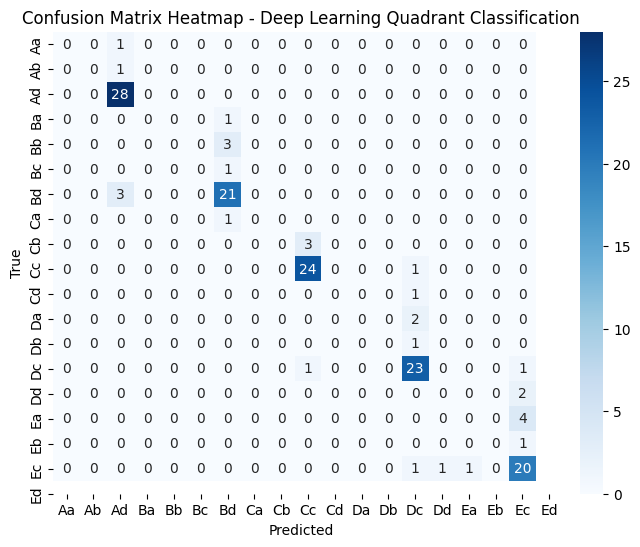

In [207]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# -----------------------------
# 1. Predict บน Test set
# -----------------------------
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# -----------------------------
# 2. สร้าง Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_true_labels, y_pred_labels)

# -----------------------------
# 3. วาด Heatmap
# -----------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap - Deep Learning Quadrant Classification")
plt.show()


In [212]:
import numpy as np
import pandas as pd

# -----------------------------
# 1. Predict บน Test set
# -----------------------------
y_pred = model.predict(X_test)

# แปลง one-hot → class index
y_true_idx = np.argmax(y_test, axis=1)
y_pred_idx = np.argmax(y_pred, axis=1)

# -----------------------------
# 2. แปลงเป็น label จริง
# -----------------------------
y_true_labels = le.inverse_transform(y_true_idx)
y_pred_labels = le.inverse_transform(y_pred_idx)

# -----------------------------
# 3. สร้าง DataFrame ของผลการทดสอบ
# -----------------------------
df_results = pd.DataFrame({
    "True Quadrant": y_true_labels,
    "Predicted Quadrant": y_pred_labels
})

# ✅ แสดง 10 แถวแรก
df_results.head(10)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,True Quadrant,Predicted Quadrant
0,Ed,Ed
1,Ba,Bd
2,Ed,Ed
3,Ad,Ad
4,Bd,Bd
5,Bd,Bd
6,Bd,Bd
7,Cd,Cd
8,Ed,Ed
9,Dd,Dd


In [213]:
import plotly.express as px
import pandas as pd

# -----------------------------
# 1. แตก True Quadrant ออกเป็น Fundamental (A–E) และ Trend (a–e)
# -----------------------------
df_results['Fundamental'] = df_results['Predicted Quadrant'].str[0]   # ตัวแรก เช่น A, B, C, D, E
df_results['Trend'] = df_results['Predicted Quadrant'].str[1]        # ตัวสอง เช่น a, b, c, d, e

# -----------------------------
# 2. สร้าง Pivot Table
# -----------------------------
heatmap_data = pd.pivot_table(
    df_results,
    index="Fundamental", columns="Trend",
    values="Predicted Quadrant",
    aggfunc="count", fill_value=0
)

# -----------------------------
# 3. Plot Heatmap
# -----------------------------
fig = px.imshow(
    heatmap_data,
    text_auto=True,
    color_continuous_scale="YlOrRd",
    labels=dict(x="Trend (a–e)", y="Fundamental Group (A–E)", color="Stock Count"),
    title="📊 Quadrant Heatmap (Predicted by ANN)"
)

fig.update_layout(xaxis_title="Trend (a–e)", yaxis_title="Fundamental Group (A–E)")
fig.show()
